# Tạo mạng CNN cho Phân loại giống chó sử dụng Transfer Learning (ResNet50 model)

In [1]:
from glob import glob

dog_names = [
    item[20:-1].replace("_", " ").replace("-", " ").lower()
    for item in sorted(glob("dogImages/train/*/"))
]
CLASS_NUM = len(dog_names)

In [2]:
# Load pretrained-model
import numpy as np

bottleneck_features = np.load("bottleneck_features/DogResnet50Data.npz")
train_ResNet50 = bottleneck_features["train"]
valid_ResNet50 = bottleneck_features["valid"]
test_ResNet50 = bottleneck_features["test"]

In [3]:
# Xác định kiến trúc mô hình
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Sequential

ResNet_model = Sequential()
ResNet_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
ResNet_model.add(Dense(CLASS_NUM, activation="softmax"))
ResNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 133)               272517    
                                                                 
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Biên dịch Model
from keras.optimizers import Adamax

ResNet_model.compile(
    loss="categorical_crossentropy",
    optimizer=Adamax(learning_rate=0.002),
    metrics=["accuracy"],
)

In [5]:
from keras.utils import np_utils
from sklearn.datasets import load_files


def load_targets(path):
    data = load_files(path)
    return np_utils.to_categorical(np.array(data["target"]), CLASS_NUM)


train_targets = load_targets("dogImages/train")
valid_targets = load_targets("dogImages/valid")
test_targets = load_targets("dogImages/test")

In [6]:
# Train Model
from keras.callbacks import ModelCheckpoint

check_pointer = ModelCheckpoint(
    filepath="saved_models/weights.best_adamax.ResNet50.hdf5",
    verbose=1,
    save_best_only=True,
)

EPOCHS = 30
BATCH_SIZE = 64

ResNet_model.fit(
    train_ResNet50,
    train_targets,
    validation_data=(valid_ResNet50, valid_targets),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[check_pointer],
    verbose=1,
)

Epoch 1/30
100/105 [===========================>..] - ETA: 0s - loss: 2.3764 - accuracy: 0.4853
Epoch 1: val_loss improved from inf to 1.23080, saving model to saved_models\weights.best_adamax.ResNet50.hdf5
105/105 [==============================] - 2s 9ms/step - loss: 2.3295 - accuracy: 0.4934 - val_loss: 1.2308 - val_accuracy: 0.7054
Epoch 2/30
102/105 [============================>.] - ETA: 0s - loss: 0.7739 - accuracy: 0.8358
Epoch 2: val_loss improved from 1.23080 to 0.90888, saving model to saved_models\weights.best_adamax.ResNet50.hdf5
105/105 [==============================] - 1s 7ms/step - loss: 0.7754 - accuracy: 0.8361 - val_loss: 0.9089 - val_accuracy: 0.7557
Epoch 3/30
102/105 [============================>.] - ETA: 0s - loss: 0.5130 - accuracy: 0.9036
Epoch 3: val_loss improved from 0.90888 to 0.76407, saving model to saved_models\weights.best_adamax.ResNet50.hdf5
105/105 [==============================] - 1s 8ms/step - loss: 0.5120 - accuracy: 0.9036 - val_loss: 0.7641 -

In [7]:
EPOCHS = 5
BATCH_SIZE = 64

ResNet_model.fit(
    train_ResNet50,
    train_targets,
    validation_data=(valid_ResNet50, valid_targets),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[check_pointer],
    verbose=1,
)

Epoch 1/5
 95/105 [==========================>...] - ETA: 0s - loss: 0.0107 - accuracy: 0.9984
Epoch 1: val_loss did not improve from 0.51767
105/105 [==============================] - 1s 8ms/step - loss: 0.0106 - accuracy: 0.9985 - val_loss: 0.5371 - val_accuracy: 0.8455
Epoch 2/5
 99/105 [===========================>..] - ETA: 0s - loss: 0.0094 - accuracy: 0.9989
Epoch 2: val_loss did not improve from 0.51767
105/105 [==============================] - 1s 7ms/step - loss: 0.0095 - accuracy: 0.9988 - val_loss: 0.5373 - val_accuracy: 0.8527
Epoch 3/5
 98/105 [===========================>..] - ETA: 0s - loss: 0.0089 - accuracy: 0.9987
Epoch 3: val_loss did not improve from 0.51767
105/105 [==============================] - 1s 7ms/step - loss: 0.0089 - accuracy: 0.9988 - val_loss: 0.5468 - val_accuracy: 0.8551
Epoch 4/5
 99/105 [===========================>..] - ETA: 0s - loss: 0.0084 - accuracy: 0.9983
Epoch 4: val_loss did not improve from 0.51767
105/105 [==============================

In [8]:
# Load Weight Model với Validation loss tốt nhất
ResNet_model.load_weights("saved_models/weights.best_adamax.ResNet50.hdf5")
ResNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 133)               272517    
                                                                 
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Kiểm tra Model
ResNet50_predictions = [
    np.argmax(ResNet_model.predict(np.expand_dims(feature, axis=0)))
    for feature in test_ResNet50
]

# Độ chính xác
test_accuracy = (
    100
    * np.sum(np.array(ResNet50_predictions) == np.argmax(test_targets, axis=1))
    / len(ResNet50_predictions)
)
print(f"Độ chính xác {test_accuracy:.2f}%")

1/1 [==============================] - 0s 29ms/step
Độ chính xác 83.37%


In [10]:
from keras.utils import img_to_array, load_img


def path_to_tensor(img_path):
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    return np.expand_dims(x, axis=0)

In [11]:
import cv2
import matplotlib.pyplot as plt
from extract_bottleneck_features import extract_Resnet50


def ResNet50_predict_breed(img_path):
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    print(bottleneck_feature.shape)
    predicted_vector = ResNet_model.predict(bottleneck_feature)
    breed = dog_names[np.argmax(predicted_vector)]
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    print(f"Đây là giống chó {breed}")

1/1 [==============================] - 1s 1s/step
(1, 7, 7, 2048)
1/1 [==============================] - 0s 14ms/step
Đây là giống chó akita


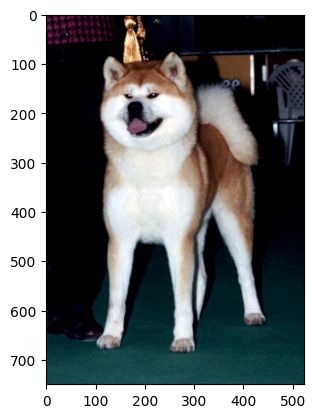

In [14]:
ResNet50_predict_breed("dogImages/test/004.Akita/Akita_00296.jpg")

In [13]:
import keras

keras.models.save_model(
    model=ResNet_model,
    filepath="saved_models/ResNet_model.h5",
    overwrite=True,
)